In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [3]:
from tqdm import tqdm
import copy
import numpy as np

In [4]:
import torch
import torchvision
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Custom files.
from model import DiffusionModel
from training import get_config, ImgDataset, evaluate_model, demo, generate_img
from diffusion import diffusion_loss
import federated_learning as fl

import utils

In [6]:
# Define dataset and settings.
# dataset_name = 'cifar_10'
# dataset_name = 'svhn'
dataset_name = 'fashion_mnist'

# Define distribution settings.
num_clients = 10      # [10, 30, 50]
beta = 0.5            # [0.1, 0.5, 5]

if num_clients == 10:
    num_participation = 10
elif num_clients == 30:
    num_participation = 10
elif num_clients == 50:
    num_participation = 10
client_idxes = list(range(num_clients))

client_data_dir = os.path.join('./client_data/', dataset_name + '_b_{}_c_{}'.format(beta, num_clients))

In [7]:
data_config, train_config = get_config(dataset_name)
print(data_config)
print(train_config)

# Data config.
# img_size = data_config['img_size']
# channels = data_config['channels']
batch_size = data_config['batch_size']
train_transform = data_config['train_transform']
test_transform = data_config['test_transform']

# Training config.
lr = train_config['lr']
timesteps = train_config['timesteps']
num_rounds = train_config['rounds']
num_local_epochs = train_config['local_epochs']
eta = train_config['eta']
save_interval = train_config['save_interval']

# num_local_epochs = 1               # 1, 5, 10, 15

save_dir = os.path.join('./output/diffusion_fedavg', dataset_name + '_b_{}_c_{}_le_{}'.format(beta, num_clients, num_local_epochs))
os.makedirs(save_dir, exist_ok=True)

{'img_size': 32, 'channels': 3, 'batch_size': 512, 'train_transform': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    Normalize(mean=[0.5], std=[0.5])
), 'test_transform': Compose(
    ToTensor()
    Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
    Normalize(mean=[0.5], std=[0.5])
)}
{'lr': 0.0002, 'timesteps': 300, 'epochs': 1500, 'rounds': 300, 'local_epochs': 5, 'ema_decay': 0.998, 'eta': 1.0, 'save_interval': 100}


In [8]:
# Data.
data_dir = os.path.join('../datasets/', dataset_name)

# Centralized testset for global model evaluation.
test_dir = os.path.join(data_dir, 'test')
test_data = ImgDataset(test_dir, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4, persistent_workers=True, pin_memory=True)

In [9]:
# Define client data.
client_loaders = []
for client_idx in range(num_clients):
    data_dir = os.path.join(client_data_dir, str(client_idx))
    dataset = ImgDataset(data_dir, transform=train_transform)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, persistent_workers=True, pin_memory=True)
    client_loaders.append(data_loader)

{0: 'Ankle boot', 1: 'Bag', 2: 'Coat', 3: 'Dress', 4: 'Pullover', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'T-shirt top', 9: 'Trouser'}


/home/yelintun/anaconda3/envs/ssl_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/yelintun/anaconda3/envs/ssl_env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None

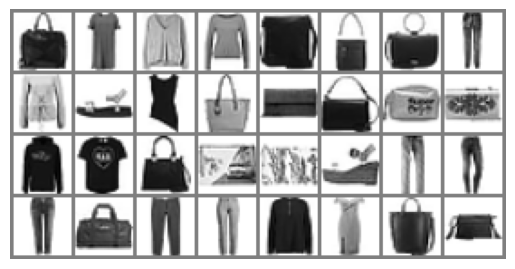

In [10]:
client_loader = client_loaders[0]

# Useful for image generation later. Just to check which images are generated.
label_idx_dict = client_loader.dataset.label_idx_dict
idx_label_dict = {idx: label for label, idx in label_idx_dict.items()}
print(idx_label_dict)

num_classes = len(idx_label_dict)

# Print a few images.
dataiter = iter(client_loader)
images, labels = next(dataiter)
utils.show_img_tensor(torchvision.utils.make_grid(images[:32]))

In [11]:
# Global model.
glob_model = DiffusionModel().to(device)

# For logging model performance.
performance_dict, performance_log = dict(), dict()
metric_keys = ['g_train_loss', 'g_test_loss']
for metric in metric_keys:
    performance_dict[metric] = utils.MeanMetric()
    performance_log[metric] = list()

# performance_dict, performance_log = utils.get_performance_loggers(metric_keys)

In [12]:
# Automatic resuming from checkpoint.
log_path = os.path.join(save_dir, 'performance_log.pickle')
if os.path.isfile(log_path):
    performance_log = utils.load_pickle(log_path)
start_round = len(performance_log[metric_keys[0]])

if start_round > 0:
    glob_model.load_state_dict(torch.load(os.path.join(save_dir, 'g_r_{}.pth'.format(start_round))))

In [13]:
glob_w = glob_model.state_dict()

optim_args = {'lr': lr}

for round_no in range(start_round, num_rounds):
    utils.print_separator(text='Round: {} / {}'.format(round_no + 1, num_rounds))
                
    participating_clients = sorted(np.random.choice(client_idxes, size=num_participation, replace=False))
    print('participating_clients:', participating_clients)
    
    # Local training.
    glob_model.train()
    client_updates = dict()
    for client_idx in participating_clients:  
        print('client:', client_idx)
        client_loader = client_loaders[client_idx]
        
        # Local training.
        client_update = fl.local_update_fedavg(glob_model, client_loader, num_local_epochs, optim_args, test_loader=test_loader)
        
        # For weighted averaging.
        client_updates.setdefault('local_w', list()).append(client_update['local_w'])
        client_updates.setdefault('num_samples', list()).append(client_update['num_samples'])
        
        # Logging client performance.
        performance_log.setdefault('c_{}_train_loss'.format(client_idx), list()).append(client_update['train_loss'])
        performance_log.setdefault('c_{}_test_loss'.format(client_idx), list()).append(client_update['test_loss'])
            
    # Model aggregation.
    glob_w = fl.weighted_averaging(client_updates['local_w'], client_updates['num_samples'])
    glob_model.load_state_dict(glob_w)
    
    # Evaluate global model on local datasets.
    for client_idx in participating_clients:
        g_train_loss = evaluate_model(glob_model, client_loader, diffusion_loss, tqdm_desc='g_train_loss')
        performance_dict['g_train_loss'].update_state(g_train_loss)
        
    # Average local performace of global model.
    performance_log['g_train_loss'].append(performance_dict['g_train_loss'].result())
    performance_dict['g_train_loss'].reset_state()
    
    # Evaluate global model on global testset.
    g_test_loss = evaluate_model(glob_model, test_loader, diffusion_loss, tqdm_desc='g_test_loss')
    performance_log['g_test_loss'].append(g_test_loss)
    
#     for key in sorted(performance_log.keys()):
#         print(key, ': ',  performance_log[key][-1])
    
    for key in sorted(metric_keys):
        print(key, ': ',  performance_log[key][-1])
    
    # Save global model.
    if (round_no + 1) % save_interval == 0:
        torch.save(glob_model.state_dict(), os.path.join(save_dir, 'g_r_{}.pth'.format(round_no + 1)))
        utils.save_pickle(log_path, performance_log)
        clear_output(wait=True)

    # Save client models only in the last round. To save space.
#     if round_no + 1 == num_rounds:
#         for client_idx in range(num_clients):
#             local_state_dict = client_updates['local_w'][client_idx]
#             torch.save(local_state_dict, os.path.join(save_dir, 'c_{}_r_{}.pth'.format(client_idx, round_no + 1)))

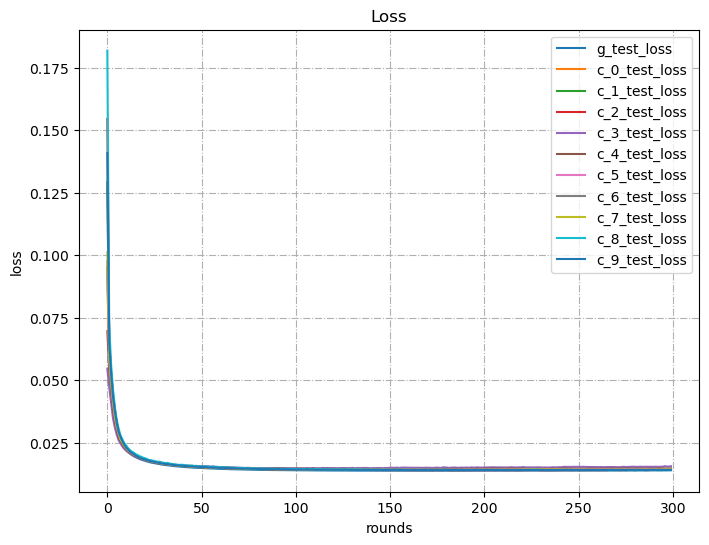

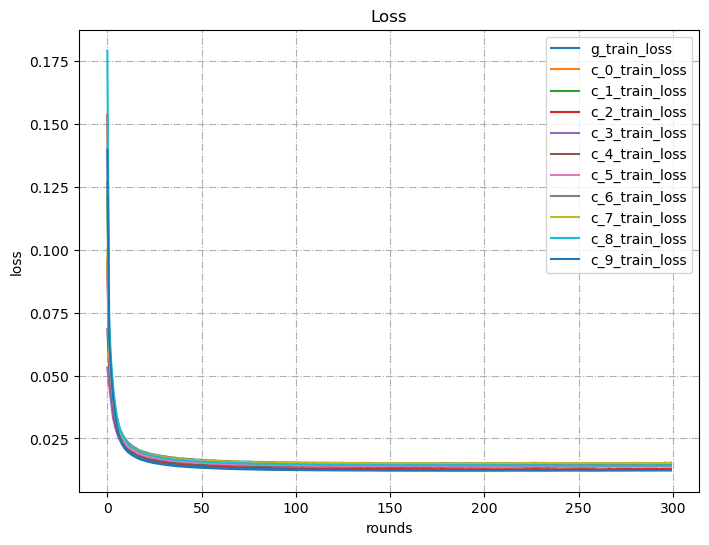

In [14]:
# Plot training history.
performance_log = utils.load_pickle(log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'test_loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'rounds'
loss_plot_config['labels'] = ['g_test_loss'] + ['c_{}_test_loss'.format(client_idx) for client_idx in range(num_clients)]
loss_plot_config['attributes'] = ['g_test_loss'] + ['c_{}_test_loss'.format(client_idx) for client_idx in range(num_clients)]
utils.save_history_plot(performance_log, loss_plot_config)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'train_loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'rounds'
loss_plot_config['labels'] = ['g_train_loss'] + ['c_{}_train_loss'.format(client_idx) for client_idx in range(num_clients)]
loss_plot_config['attributes'] = ['g_train_loss'] + ['c_{}_train_loss'.format(client_idx) for client_idx in range(num_clients)]
utils.save_history_plot(performance_log, loss_plot_config)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:02<00:00, 118.02it/s]


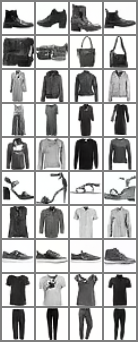

In [15]:
# Reload saved global model for generation.
glob_model = DiffusionModel().to(device)
glob_model.load_state_dict(torch.load(os.path.join(save_dir, 'g_r_{}.pth'.format(num_rounds))))

img_folder = os.path.join(save_dir, 'images')
os.makedirs(img_folder, exist_ok=True)

# Generate and save image.
img_path = os.path.join(img_folder, 'g_final.png')
# demo(glob_model, img_path, timesteps, eta)
demo(glob_model, img_path, timesteps, eta, num_images=4, seed=0)
# demo(glob_model, img_path, timesteps, eta, num_images=40, classes=[9], num_img_per_row=10)

0


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 216.11it/s]


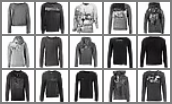


1


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 224.55it/s]


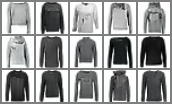


2


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 224.45it/s]


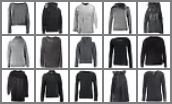


3


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 226.39it/s]


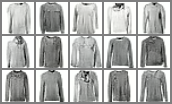


4


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 227.30it/s]


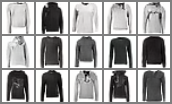


5


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 221.77it/s]


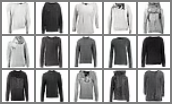


6


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 226.48it/s]


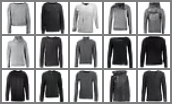


7


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 225.16it/s]


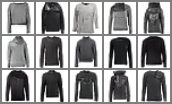


8


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 221.18it/s]


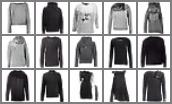


9


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 225.35it/s]


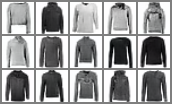

In [16]:
# Reload saved client models for generation.
local_model = DiffusionModel().to(device)
for client_idx in range(num_clients):
    print(client_idx)
    local_model.load_state_dict(torch.load(os.path.join(save_dir, 'c_{}_r_{}.pth'.format(client_idx, num_rounds))))
    img_path = os.path.join(img_folder, 'c_{}_final.png'.format(client_idx))
#     demo(local_model, img_path, timesteps, eta)
    demo(local_model, img_path, timesteps, eta, num_images=15, classes=[4], num_img_per_row=5)

In [17]:
# Generate images for evaluation.
# idx_label_dict = {v: k for k, v in test_data.label_idx_dict.items()}
# for idx, label in idx_label_dict.items():
#     num_imgs = test_data.label_count_dict[label]
#     img_class = idx
#     class_dir = os.path.join(save_dir, 'generated_img', label)
#     os.makedirs(class_dir, exist_ok=True)
#     generate_img(glob_model, class_dir, timesteps, eta, num_imgs, img_class)

In [18]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")